## Deep Q-Learning Agent

Code is based on and partly copied from these two sources: 
- https://arshren.medium.com/deep-q-learning-a-deep-reinforcement-learning-algorithm-f1366cf1b53d
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

NOTE: Do not forget to change this notebook into a .py file before submission. Also, save and load the model after it has been trained.

In [35]:
# importing required libraries
# import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display

In [36]:
import os
cwd = os.getcwd()
cwd
# new_path = cwd[:-8]
# new_path

'c:\\Users\\20174216\\OneDrive - TU Eindhoven\\Documents\\1. TUe MSc DSAI\\Q4\\2AMC15 - Data Intelligence Challenge\\2AMC15-2023-DIC'

In [37]:
os.chdir('c:\\Users\\20174216\\OneDrive - TU Eindhoven\\Documents\\1. TUe MSc DSAI\\Q4\\2AMC15 - Data Intelligence Challenge\\2AMC15-2023-DIC')

In [38]:
#TODO: Fix the imports below, since they are required for the notebook to function.

from world import Environment
from world import Grid
from world import agent_vision

from pathlib import Path

In [39]:
plt.ion()

# setting the device
# if gpu is to be used for Mac OS
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# if gpu is to be used for cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [40]:
# structure of the Experiences to store
Experience = namedtuple('Experience', 
('state', 'action', 'next_state', 'reward'))

# stores the Experience Replay buffer
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory= deque([], maxlen=capacity)
    
    def push(self, *args):
        # Save the Experience into memory 
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        #selecting a random batch of Experience for training
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

In [41]:
#TODO: Change the model to a CNN so that it can work with the agent vision input.

"""Simple MLP network."""
class DQN(nn.Module):
    """
        Args:
            n_observations: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
    def __init__(self, n_vision, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_vision, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [42]:
BATCH_SIZE = 128      # BATCH_SIZE is the number of Experience sampled from the replay buffer
GAMMA = 0.99          # GAMMA is the discount factor as mentioned in the previous section
EPSILON_START = 0.9   # EPSILON_START is the starting value of epsilon
EPSILON_END = 0.05    # EPSILON_END is the final value of epsilon
EPSILON_DECAY = 1000  # EPSILON_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005           # TAU is the update rate of the target network
LR = 1e-4             # LR is the learning rate of the AdamW optimizer
HIDDEN_SIZE = 128     # the hidden layers in the DQN

In [43]:
env = Environment(
    grid_fp=Path('grid_configs/multi_room.grd'),
    n_agents=1,
    agent_start_pos=None,
    sigma=0.0,
    no_gui=True,
    # target_fps=fps,
    random_seed=0,
    reward_fn='custom',
)

obs, info = env.get_observation()

print(obs, info)

[[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 2 4 0 1]
 [1 0 0 0 2 0 2 0 0 1]
 [1 0 0 2 3 0 2 0 0 1]
 [1 0 0 0 2 2 2 0 0 1]
 [1 0 0 0 0 3 2 3 0 1]
 [1 0 2 2 2 0 2 2 0 1]
 [1 0 0 3 2 0 0 0 0 1]
 [1 0 0 0 2 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1]] {'dirt_cleaned': [0], 'agent_moved': [False], 'agent_charging': [False], 'agent_pos': [(5, 3)]}


In [44]:
def choose_action(state):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)
    
    steps_done += 1
    if sample > epsilon_threshold:
        # max(1) will return largest column value of each row.
        # second column on max result is index of where max element was found
        # so we pick action with the larger expected reward.
        with torch.no_grad():
            return torch.tensor([torch.argmax(policy_network(state))])
    else:
        return torch.tensor([random.randint(0,3)], device=device, dtype=torch.long)

In [45]:
def plot_scores(show_result=False):
    '''
    Function to plot the durations of episodes, 
    along with an average over the last 100 episodes
    '''
    plt.figure(1)
    duration_t = torch.tensor(episode_duration, dtype= torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_t.numpy())
    # Take 100 episode averages and plot them too
    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
    else:
            display.display(plt.gcf())

In [46]:
#function that performs a single step of the optimization
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transition = memory.sample(BATCH_SIZE)
    
    '''
    # Transpose the batch and convert the  batch-array of Experience
    # to Transition of batch-arrays
    '''
    batch = Experience(*zip(*transition))
    # print('batch:', batch)
    
    #Compute a mask of non-final states and concatenate the batch element
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.stack(batch.state)
    # print('state batch:', state_batch, len(state_batch))
    action_batch = torch.stack(batch.action)
    # print('action batch:', action_batch)
    reward_batch = torch.stack(batch.reward)
    # print('reward batch:', reward_batch)

    
    # Compute Q(s_t, a)
    #These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_network(state_batch).gather(1,action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    next_state_values = torch.zeros(BATCH_SIZE,device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = reward_batch + (GAMMA* next_state_values)
    
    # Compute Huber loss
    criterion=nn.SmoothL1Loss()
    loss=criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    #optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

In [47]:
#TODO: Get the agent_vision function working.

env.reset()
obs, info = env.get_observation()
print(obs)
print(info)

agent_pos = info['agent_pos']

g = Grid(obs.shape[0], obs.shape[1])
g.cells = obs
print(agent_pos)
agent_view = agent_vision(loc=agent_pos[0], grid=g, vis_range=2)
print(agent_view)

[[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 2 4 0 1]
 [1 0 0 0 2 0 2 0 0 1]
 [1 0 0 2 3 0 2 0 0 1]
 [1 0 0 0 2 2 2 0 0 1]
 [1 0 0 0 0 3 2 3 0 1]
 [1 0 2 2 2 0 2 2 0 1]
 [1 0 0 3 2 0 0 0 0 1]
 [1 0 0 0 2 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1]]
{'dirt_cleaned': [0], 'agent_moved': [False], 'agent_charging': [False], 'agent_pos': [(5, 8)]}
[(5, 8)]
[[-1 -1  0 -1 -1]
 [-1  0  0  1 -1]
 [ 2  3  0  1 -1]
 [-1  2  0  1 -1]
 [-1 -1  0 -1 -1]]


0
1
Complete


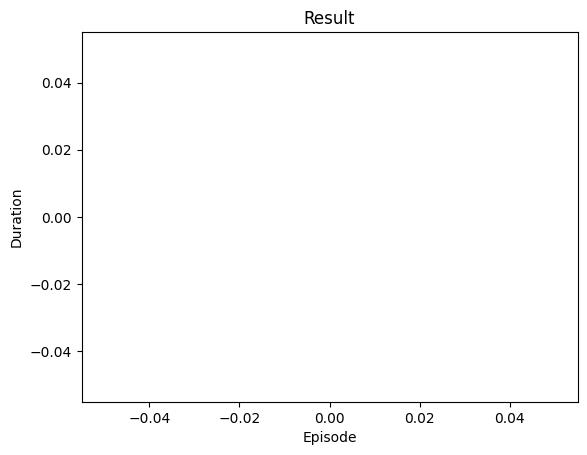

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [51]:
#TODO: Change agent_vision code if needed.

n_actions = 4
vis_range = 2
n_vision = 25
max_steps = 100

env.reset()
obs, info = env.get_observation()
agent_pos = info['agent_pos']
g = Grid(obs.shape[0], obs.shape[1])
g.cells = obs
agent_view = agent_vision(loc=agent_pos[0], grid=g, vis_range=vis_range)
agent_view = torch.flatten(torch.from_numpy(agent_view))

policy_network = DQN(n_vision, n_actions, HIDDEN_SIZE).to(device)
target_network = DQN(n_vision, n_actions, HIDDEN_SIZE).to(device)
#updates the parameters of the target network  with the parameters of the policy network 
target_network.load_state_dict(policy_network.state_dict())

optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_duration = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 2

for i in range(num_episodes):
    print(i)
    #At the beginning we reset the environment and 
    #initialize the state Tensor.
    env.reset()
    obs, info = env.get_observation()
    agent_pos = info['agent_pos']
    g = Grid(obs.shape[0], obs.shape[1])
    g.cells = obs
    agent_view = agent_vision(loc=agent_pos[0], grid=g, vis_range=vis_range)
    agent_view = torch.flatten(torch.from_numpy(agent_view))
    state = agent_view.float()
    # print('state:', state)
    total_reward = 0

    for t in range(max_steps):
        # Sample an action
        action = choose_action(state)
        # Execute it, observe the next state and the reward
        next_obs, reward, terminated, info = env.step([action])
        reward = torch.tensor([reward], device=device, dtype=torch.long)
        next_agent_pos = info['agent_pos']
        next_g = Grid(next_obs.shape[0], next_obs.shape[1])
        next_g.cells = next_obs
        next_agent_view = agent_vision(loc=next_agent_pos[0], grid=next_g, vis_range=vis_range)
        if terminated:
            break
        else:
            next_state = torch.flatten(torch.from_numpy(next_agent_view)).float()

        # Store the experience in the memory
        memory.push(state, action, next_state, reward)

        # Move to the next state and grid
        state = next_state
        obs = next_obs
        
        # Perform one step of the optimization (on the policy network)
        # The agent performs an optimization step on the Policy Network using the stored memory
        optimize_model()

        '''
        The agent will perform a soft update of the Target Network's weights, 
        with the equation TAU * policy_net_state_dict + (1-TAU) * target_net_state_dict, 
        this helps to make the Target Network's weights converge to the Policy Network's weights.
        '''
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        # policy_network.state_dict() returns the parameters of the policy network
        # target_network.load_state_dict() loads these parameters into the target network.
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_network.load_state_dict(target_net_state_dict)
        total_reward += reward

        if terminated:
            episode_duration.append(t + 1)
            print("Episode", i,"Game terminated after", t, "steps with reward", total_reward)
            
            break
        
print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()